## 1. Setup

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import librosa
import optuna
import joblib
import os

# notebook extensions
from IPython import display
from tqdm.notebook import tqdm

# feature engineering + selection
from glob import glob
from librosa import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.encoding import OrdinalEncoder

# modelling + evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
warnings.filterwarnings('ignore')

In [23]:
ls

 Volume in drive D has no label.
 Volume Serial Number is F0EB-0172

 Directory of d:\Dave's Workspace\breathelytics\notebook

08/04/2025  06:05    <DIR>          .
08/04/2025  01:53    <DIR>          ..
08/04/2025  22:47           667.132 cnn.ipynb
08/04/2025  22:23         2.247.950 main.ipynb
08/04/2025  02:01           431.499 processed_audio_features.csv
               3 File(s)      3.346.581 bytes
               2 Dir(s)   6.151.110.656 bytes free


In [24]:
base_audio_files = glob('../../audioscopeAI/src/audioscopeAI_AI-ML/Respiratory_Sound_Database/audio_and_txt_files/*.wav')

all_audio = {}

for audio_file in tqdm(base_audio_files, desc="Loading audio files"):
    # extract filename from path
    filename = audio_file.split('\\')[-1] # for Windows paths

    # load audio file
    y, sr = librosa.load(audio_file, mono=True)
    
    # store in dictionary
    all_audio[filename] = {
        'data': y,
        'sample_rate': sr
    }

print(f'Loaded {len(all_audio)} audio files')

Loading audio files:   0%|          | 0/920 [00:00<?, ?it/s]

Loaded 920 audio files


In [25]:
list(all_audio.keys())[:5] 

['101_1b1_Al_sc_Meditron.wav',
 '101_1b1_Pr_sc_Meditron.wav',
 '102_1b1_Ar_sc_Meditron.wav',
 '103_2b2_Ar_mc_LittC2SE.wav',
 '104_1b1_Al_sc_Litt3200.wav']

## 2. Data Preprocessing

Shortest audio file: 124_1b1_Pr_sc_Litt3200.wav
Duration: 7.86 seconds


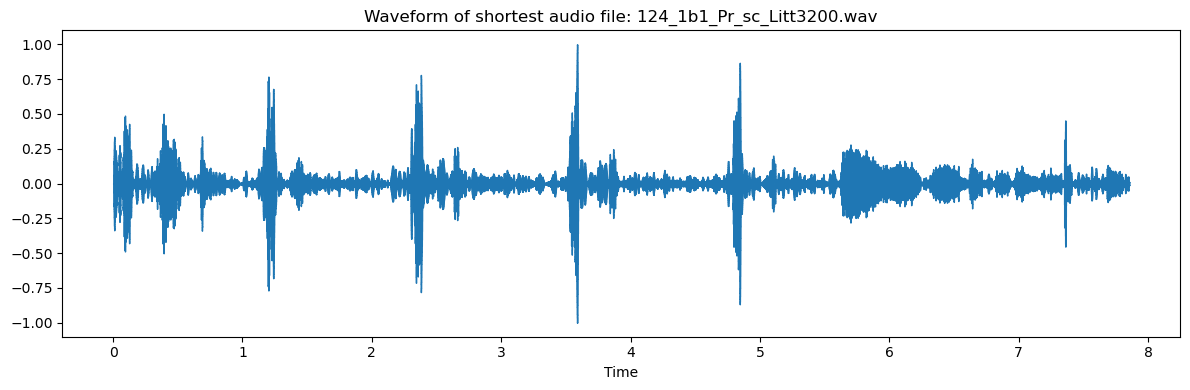

In [26]:
# calculate duration for each audio file
for filename, audio_info in all_audio.items():
    duration = len(audio_info['data']) / audio_info['sample_rate']
    all_audio[filename]['duration'] = duration

# find the file with the minimum duration
min_duration_file = min(all_audio.items(), key=lambda x: x[1]['duration'])
min_filename = min_duration_file[0]
min_audio_info = min_duration_file[1]

print(f"Shortest audio file: {min_filename}")
print(f"Duration: {min_audio_info['duration']:.2f} seconds")

# plot the waveform of the shortest audio file
plt.figure(figsize=(12, 4))
librosa.display.waveshow(min_audio_info['data'], sr=min_audio_info['sample_rate'])
plt.title(f"Waveform of shortest audio file: {min_filename}")
plt.tight_layout()
plt.show()

display.Audio(data=min_audio_info['data'], rate=min_audio_info['sample_rate'])

In [27]:
target_duration = min_audio_info['duration']
print(f"Duration of the shortest audio file: {target_duration} seconds")

trimmed_audio = {}

for filename, audio_info in all_audio.items():
    target_samples = int(target_duration * audio_info['sample_rate']) # calculate target samples
    trimmed_data = audio_info['data'][:target_samples] # trimmed to target duration

    # store in dictionary
    trimmed_audio[filename] = {
        'data': trimmed_data,
        'sample_rate': audio_info['sample_rate'],
        'duration': target_duration
    }

print(f'Trimmed all {len(trimmed_audio)} audio files to {target_duration} seconds')

Duration of the shortest audio file: 7.8560090702947845 seconds
Trimmed all 920 audio files to 7.8560090702947845 seconds


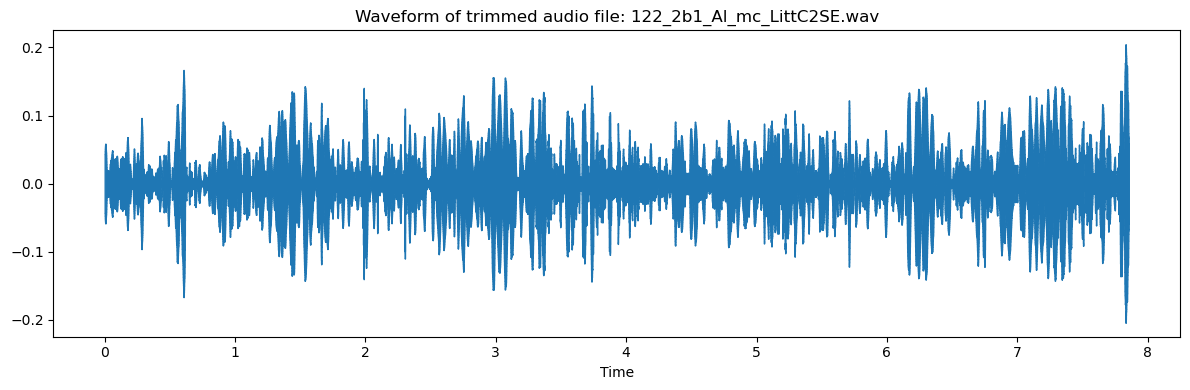

In [28]:
# plot the waveform of a sample trimmed audio file
sample_file = list(trimmed_audio.keys())[90]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(trimmed_audio[sample_file]['data'], sr=trimmed_audio[sample_file]['sample_rate'])
plt.title(f"Waveform of trimmed audio file: {sample_file}")
plt.tight_layout()
plt.show()

## 3. Feature Extraction

In [33]:
def feature_extraction(base_audio_files):
    x, sample_rate = librosa.load(base_audio_files)
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=13).T, axis=0)

    return mfcc

In [ ]:
features = {}

for audio in tqdm(base_audio_files, desc="Extracting features"):
    filename = audio.split('\\')[-1] # for Windows paths
    mfccs = feature_extraction(audio)

    features[filename] = mfccs

mfcc_df = pd.DataFrame([features[filename] for filename in features.keys()])

# add column names
mfcc_df.columns = [f'mfcc_{i}' for i in range(len(mfcc_df.columns))]
mfcc_df['filename'] = list(features.keys())

print(f"MFCC dataframe shape: {mfcc_df.shape}")
mfcc_df.head()


Extracting features:   0%|          | 0/920 [00:00<?, ?it/s]

MFCC dataframe shape: (920, 14)


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,filename
0,-528.425232,104.517365,69.907585,42.572124,31.213381,27.490580,22.207005,16.551100,15.276698,16.680298,14.642213,8.426925,3.857193,101_1b1_Al_sc_Meditron.wav
1,-582.504700,95.394691,57.402180,31.435291,28.148777,33.527466,31.569719,22.792307,16.643297,15.632527,14.031040,9.272127,5.846709,101_1b1_Pr_sc_Meditron.wav
2,-596.806091,116.009735,60.592537,25.570189,26.233389,38.501705,36.034607,18.649155,3.548372,0.805531,5.737569,9.666626,9.134827,102_1b1_Ar_sc_Meditron.wav
3,-418.433228,68.255913,48.025726,33.063881,27.974850,26.455481,22.683329,18.157923,15.907789,15.104877,13.302152,10.846485,9.630449,103_2b2_Ar_mc_LittC2SE.wav
4,-441.498169,100.994278,74.064339,43.248154,19.710049,7.843437,5.497488,8.012251,11.732349,14.880522,16.776686,17.138563,15.964789,104_1b1_Al_sc_Litt3200.wav
